In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [3]:
df = pd.read_csv('./hw2/training.csv', sep=',')

In [4]:
# check data

df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [5]:
# list columns

df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [9]:
# check if nan

df.isnull().values.any()

False

In [24]:
df.groupby('Attrition').count()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,
No,987,987,987,987,987,987,987,987,987,987,...,987,987,987,987,987,987,987,987,987,987
Yes,190,190,190,190,190,190,190,190,190,190,...,190,190,190,190,190,190,190,190,190,190


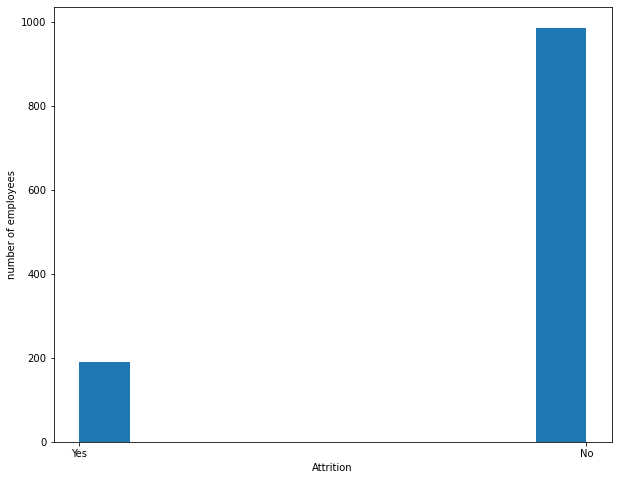

In [25]:
# check category label

plt.figure(figsize=(10,8))
plt.hist(df.Attrition)
plt.xlabel('Attrition')
plt.ylabel('number of employees')
plt.show()

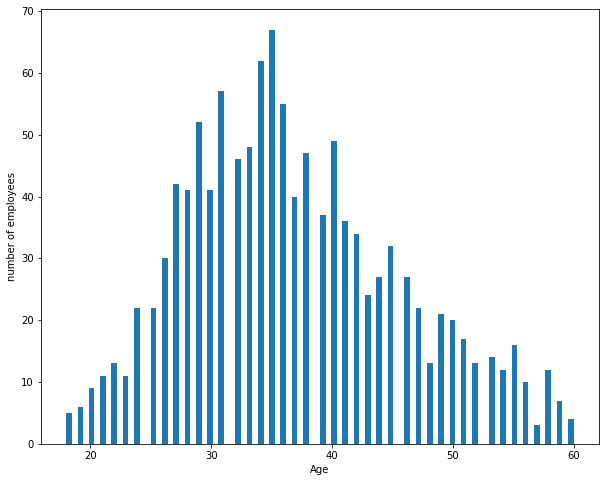

In [29]:
plt.figure(figsize=(10,8))
plt.hist(df.Age, bins=90)
plt.xlabel('Age')
plt.ylabel('number of employees')
plt.show()

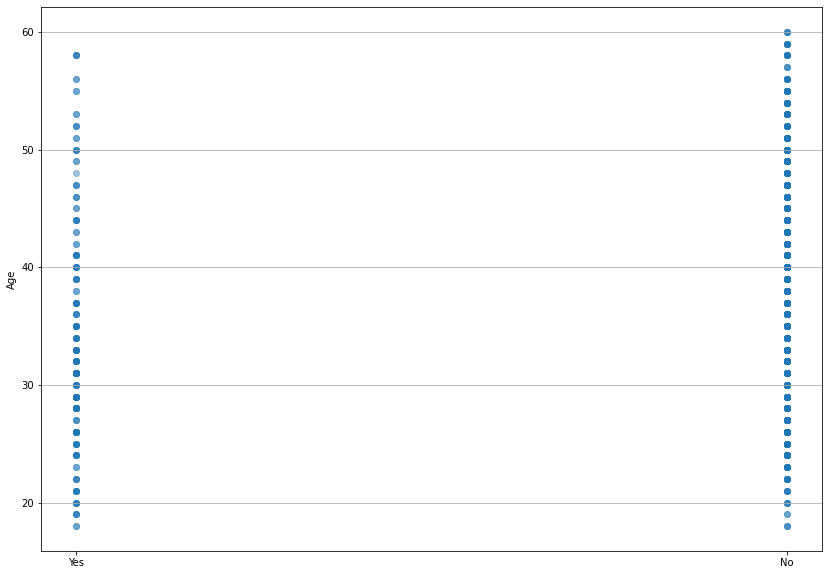

In [35]:
plt.figure(figsize=(14,10))
plt.scatter(df.Attrition, df.Age, alpha=0.4)
plt.ylabel('Age')
plt.grid(b=True, which='major', axis='y')
plt.show()